In [1]:
import cv2
import skimage
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, Model
from tensorflow.keras.backend import epsilon
from tensorflow.keras.metrics import Metric
from tensorflow.keras.layers import Dropout, BatchNormalization, UpSampling2D
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from patchify import patchify
from tensorflow.keras.models import load_model
from skan import Skeleton, summarize
import networkx as nx
from skimage.morphology import skeletonize
from stable_baselines3 import PPO
import sys
sys.path.insert(1, r'C:\Users\benjm\Documents\GitHub\2023-24-fai2-adsai-BenjaminGraziadei223946\3. Reinforcement Learning')
from ot2_env_wrapper import OT2Env

In [2]:
cut_images = []
predicted_masks = []
post_processed_masks = []

In [3]:
folder = r'C:\Users\benjm\Documents\GitHub\2023-24-fai2-adsai-BenjaminGraziadei223946\1. Computer Vision\measurement'
for image in os.listdir(folder):
    image_path = os.path.join(folder, image)
    im = cv2.imread(image_path, 0)
    if image.endswith(".tif"):
        im = cv2.medianBlur(im, 5)
        th, output_im = cv2.threshold(im, 10, 255, cv2.THRESH_BINARY)
        output_im = cv2.dilate(output_im, np.ones((3, 3), np.uint8), iterations=3)
        output_im = cv2.erode(output_im, np.ones((3, 3), np.uint8), iterations=10)

        retval, labels, stats, centroids = cv2.connectedComponentsWithStats(output_im)

        largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])

        x,y,w,h,_ = stats[largest_label]

        im = im[y:y+h, x:x+w]
        cut_images.append(im)
    else:
        print(image_path)

C:\Users\benjm\Documents\GitHub\2023-24-fai2-adsai-BenjaminGraziadei223946\1. Computer Vision\measurement\cut


In [4]:
num_images = len(cut_images)
patch_dir = r'C:\Users\benjm\Documents\GitHub\2023-24-fai2-adsai-BenjaminGraziadei223946\1. Computer Vision\pipeline_patches'

In [5]:
def create_and_save_patches(patch_size):
    def padder(image, patch_size):
        h = image.shape[0]
        w = image.shape[1]
        height_padding = ((h // patch_size) + 1) * patch_size - h
        width_padding = ((w // patch_size) + 1) * patch_size - w

        top_padding = int(height_padding/2)
        bottom_padding = height_padding - top_padding

        left_padding = int(width_padding/2)
        right_padding = width_padding - left_padding        
        padded_image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])

        return padded_image

    for img_idx, image in enumerate(cut_images):
        print(img_idx)
        image = padder(image, patch_size)

        # Create image patches
        image_patches = patchify(image, (patch_size, patch_size), step=patch_size)
        image_patches = image_patches.reshape(-1, patch_size, patch_size)

        # Save image patches
        for patch_index, img_patch in enumerate(image_patches):
                image_patch_path = f'{patch_dir}\\{img_idx}_{patch_index}.png'
                cv2.imwrite(image_patch_path, img_patch)

In [6]:

create_and_save_patches(256)

0


In [7]:
def create_weight_map(mask_shape, center_weight=10, border_weight=1):
    """
    Create a weight map for a mask, with higher weights in the center and lower weights at the borders.
    
    :param mask_shape: Tuple, the shape of the mask for which the weight map is created.
    :param center_weight: Float, the weight for the central region of the mask.
    :param border_weight: Float, the weight for the border region of the mask.
    :return: Numpy array, the weight map.
    """
    # Create a grid of the same shape as the mask
    xx, yy = np.meshgrid(np.arange(mask_shape[1]), np.arange(mask_shape[0]))
    
    # Calculate the center of the mask
    center_x, center_y = mask_shape[1] // 2, mask_shape[0] // 2
    
    # Calculate the distance of each point from the center
    distances_from_center = np.sqrt((xx - center_x)**2 + (yy - center_y)**2)
    
    # Normalize distances to range between 0 and 1
    max_distance = np.sqrt(center_x**2 + center_y**2)
    normalized_distances = distances_from_center / max_distance
    
    # Create the weight map where the center has `center_weight` and borders have `border_weight`
    weight_map = (1 - normalized_distances) * (center_weight - border_weight) + border_weight
    
    return weight_map

# Example usage:
mask_shape = (256, 256)  # The shape of your mask patches
weight_map = create_weight_map(mask_shape, center_weight=10, border_weight=1)


In [8]:
class F1Score(Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name="tp", initializer="zeros")
        self.false_positives = self.add_weight(name="fp", initializer="zeros")
        self.false_negatives = self.add_weight(name="fn", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(tf.round(y_pred), tf.float32)          # for mixed precision training
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.round(y_pred)
        true_positives = tf.reduce_sum(tf.cast(y_true * y_pred, "float"), axis=0)
        false_positives = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, "float"), axis=0)
        false_negatives = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), "float"), axis=0)

        self.true_positives.assign_add(tf.reduce_sum(true_positives))
        self.false_positives.assign_add(tf.reduce_sum(false_positives))
        self.false_negatives.assign_add(tf.reduce_sum(false_negatives))

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + epsilon())
        return 2 * (precision * recall) / (precision + recall + epsilon())

    def reset_state(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)

# Define IoU
class IoU(Metric):
    def __init__(self, name='iou', **kwargs):
        super(IoU, self).__init__(name=name, **kwargs)
        self.intersection = self.add_weight(name="intersection", initializer="zeros")
        self.union = self.add_weight(name="union", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(tf.round(y_pred), tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.round(y_pred)
        intersection = tf.reduce_sum(y_true * y_pred)
        union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection

        self.intersection.assign_add(intersection)
        self.union.assign_add(union)

    def result(self):
        return self.intersection / (self.union + epsilon())

    def reset_state(self):
        self.intersection.assign(0)
        self.union.assign(0)

In [9]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, concatenate

def resnet_unet(input_size, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_size, classes=1)

    # Use feature maps from ResNet model
    conv4 = base_model.get_layer('conv4_block6_out').output
    conv3 = base_model.get_layer('conv3_block4_out').output
    conv2 = base_model.get_layer('conv2_block3_out').output
    conv1 = base_model.get_layer('conv1_relu').output

    up4 = UpSampling2D((2, 2))(conv4)
    up4 = concatenate([up4, conv3])
    up4 = Conv2D(256, (3, 3), activation='relu', padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Dropout(0.2)(up4)
    
    up3 = UpSampling2D((2, 2))(up4)
    up3 = concatenate([up3, conv2])
    up3 = Conv2D(128, (3, 3), activation='relu', padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Dropout(0.2)(up3)

    up2 = UpSampling2D((2, 2))(up3)
    up2 = concatenate([up2, conv1])
    up2 = Conv2D(64, (3, 3), activation='relu', padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Dropout(0.2)(up2)

    up1 = UpSampling2D((2, 2))(up2)
    up1 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Dropout(0.2)(up1)

    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(up1)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model


def weighted_loss(y_true, y_pred, weights):
    # Calculate the binary cross-entropy loss
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    
    # Apply the weights: element-wise multiplication
    weighted_bce = bce * weights
    
    # Return the mean loss
    return tf.reduce_mean(weighted_bce)

def create_weighted_loss(weights):
    def loss(y_true, y_pred):
        return weighted_loss(y_true, y_pred, weights)
    return loss

weight_map_tensor = tf.convert_to_tensor(weight_map, dtype=tf.float32)

weighted_loss_function = create_weighted_loss(weight_map_tensor)

model = resnet_unet(input_size=(256, 256, 3), num_classes=1)
optimizer = Adam(learning_rate=0.0005)
model.compile(
    optimizer=optimizer, 
    loss=weighted_loss_function, 
    metrics=[F1Score(), IoU()]
)

In [10]:
model_path = r'C:\Users\benjm\Downloads\Workspace\modelV10.h5'  # Replace with your actual model file path

# Load the model
model = load_model(model_path, custom_objects={'F1Score': F1Score(), 'IoU': IoU(), 'loss': weighted_loss_function})

# Display the model architecture
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

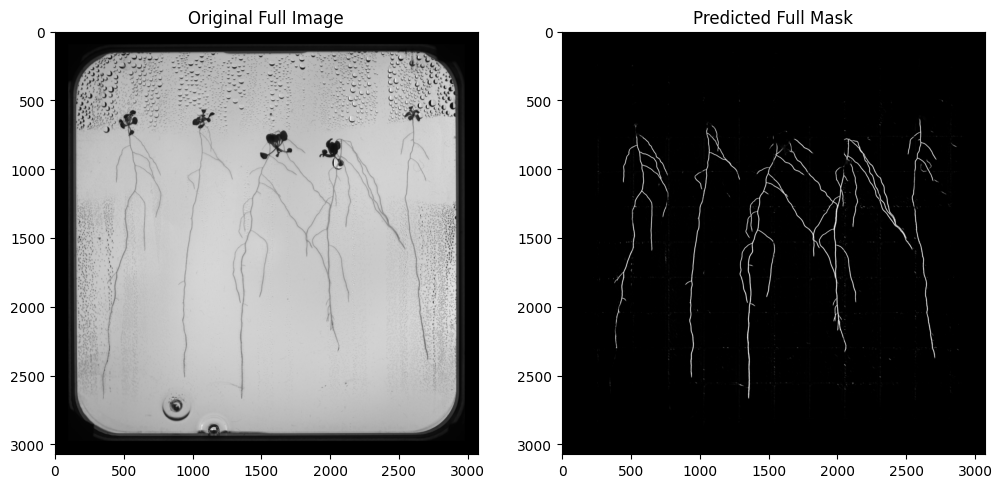

In [11]:
val_img_dir = r'C:\Users\benjm\Documents\GitHub\2023-24-fai2-adsai-BenjaminGraziadei223946\1. Computer Vision\pipeline_patches'
val_img_dir = glob.glob(os.path.join(val_img_dir, '*.png'))

# Initialize a dictionary to hold the patches for each image
img_patches = {}

# Load and sort patches
for patch_path in val_img_dir:
    file_name = os.path.basename(patch_path)
    index, patch_index = map(int, file_name.replace('.png', '').split('_'))
    patch_img = cv2.imread(patch_path)

    if index not in img_patches:
        img_patches[index] = {}

    img_patches[index][patch_index] = patch_img

# Now predict masks and reassemble
for index in sorted(img_patches.keys()):
    patches = img_patches[index]
    patch_list = [patches[i] for i in sorted(patches.keys())]

    # Reshape patches for prediction (assuming they are square)
    patch_size = patch_list[0].shape[0]  # Assuming square patches
    num_patches_per_side = int(np.sqrt(len(patch_list)))  # Assuming square layout of patches

    batch_size = 8
    num_patches = len(patch_list)
    patch_list_array = np.array(patch_list)

    predicted_patches = []
    for i in range(0, num_patches, batch_size):
        batch = patch_list_array[i:i + batch_size]
        predicted_mask_batch = model.predict(batch/255)
        predicted_patches.extend(predicted_mask_batch)

    # Convert list of patches into array for unpatchify
    predicted_patches_array = np.array(predicted_patches)
    
    combined_predicted_patches = predicted_patches_array[:,:,:,0]      #np.sum(predicted_patches_array, axis=-1)

    predicted_patches_array = combined_predicted_patches.reshape((num_patches_per_side, num_patches_per_side, patch_size, patch_size))

    patch_list_array = patch_list_array.reshape((num_patches_per_side, num_patches_per_side, patch_size, patch_size, 3))

    def manual_unpatchify(patches, full_image_size):
        num_patches_per_side,_ ,  patch_height, patch_width = patches.shape[:4]
        full_image = np.zeros(full_image_size, dtype=patches.dtype)

        for i in range(num_patches_per_side):
            for j in range(num_patches_per_side):
                if len(patches.shape) == 5:
                    full_image[i * patch_height:(i + 1) * patch_height, j * patch_width:(j + 1) * patch_width, :] = patches[i, j]
                else:  # If patches do not include a channel dimension
                    full_image[i * patch_height:(i + 1) * patch_height, j * patch_width:(j + 1) * patch_width] = patches[i, j]

        return full_image
    # Reconstruct the full image manually
    full_original_image = manual_unpatchify(patch_list_array, (3072, 3072, 3))
    full_predicted_mask = manual_unpatchify(predicted_patches_array, (3072, 3072))
    full_predicted_mask = (full_predicted_mask * 255).astype(np.uint8)

    predicted_masks.append(full_predicted_mask)


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(full_original_image)
plt.title('Original Full Image')

plt.subplot(1, 2, 2)
plt.imshow(full_predicted_mask, cmap='gray')
plt.title('Predicted Full Mask')

plt.show()

In [12]:
import cv2
import numpy as np

def circularity(contour):
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    if perimeter == 0:
        return 0
    return 4 * np.pi * (area / (perimeter * perimeter))

def process_mask(gray):
    _, binary = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY)
    close = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8), iterations=4)
    open = cv2.morphologyEx(close, cv2.MORPH_OPEN, np.ones((5, 5), np.uint8), iterations=4)

    num_labels, labels_im, stats, centroids = cv2.connectedComponentsWithStats(close, 4, cv2.CV_32S)
    density_threshold = 0.4

    # Initialize an empty mask
    component_mask = np.zeros(gray.shape, dtype=np.uint8)

    # Accumulate components that meet the density and circularity conditions
    for i, stat in enumerate(stats[1:], start=1):
        x, y, w, h, area = stat[cv2.CC_STAT_LEFT], stat[cv2.CC_STAT_TOP], stat[cv2.CC_STAT_WIDTH], stat[cv2.CC_STAT_HEIGHT], stat[cv2.CC_STAT_AREA]
        density = area / (w * h)
        if y < 500 or y > 2000:
            continue

        # Extract the component as a separate mask
        single_component_mask = np.zeros_like(binary)
        single_component_mask[labels_im == i] = 255

        # Find contours and calculate circularity
        contours, _ = cv2.findContours(single_component_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        circ_value = 0
        if contours:
            circ_value = circularity(max(contours, key=cv2.contourArea))

            # Check for area, density, and non-circularity
        if area > 2000 and density < density_threshold and circ_value < 0.3:
            component_mask[labels_im == i] = 255

    return component_mask

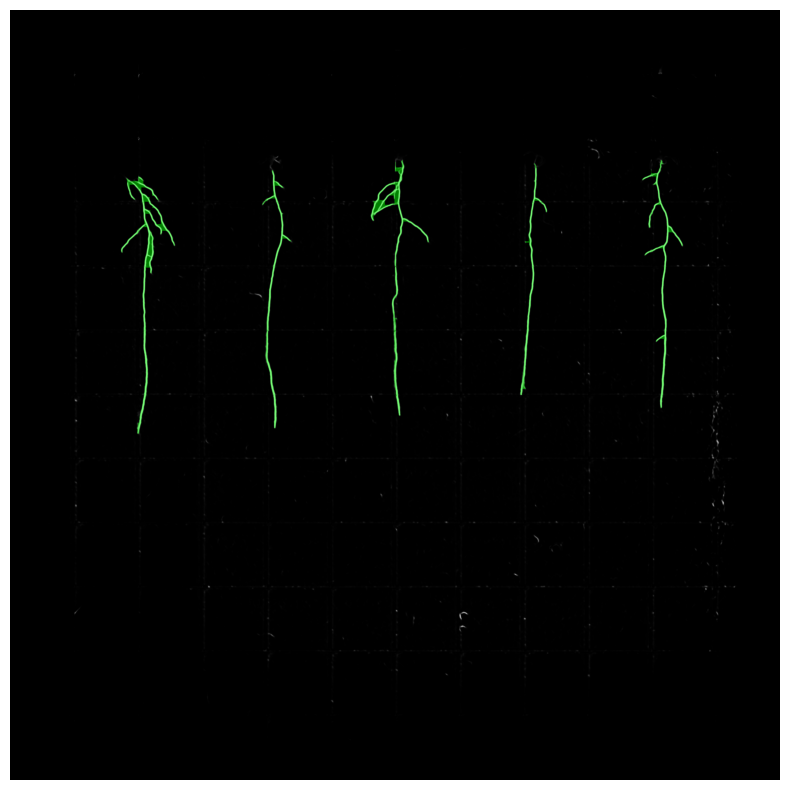

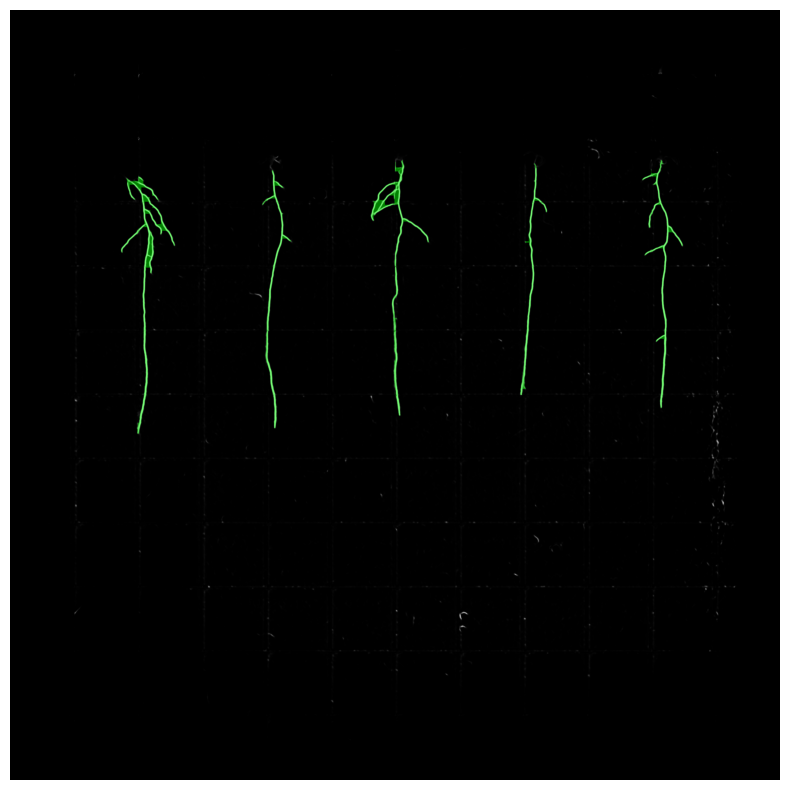

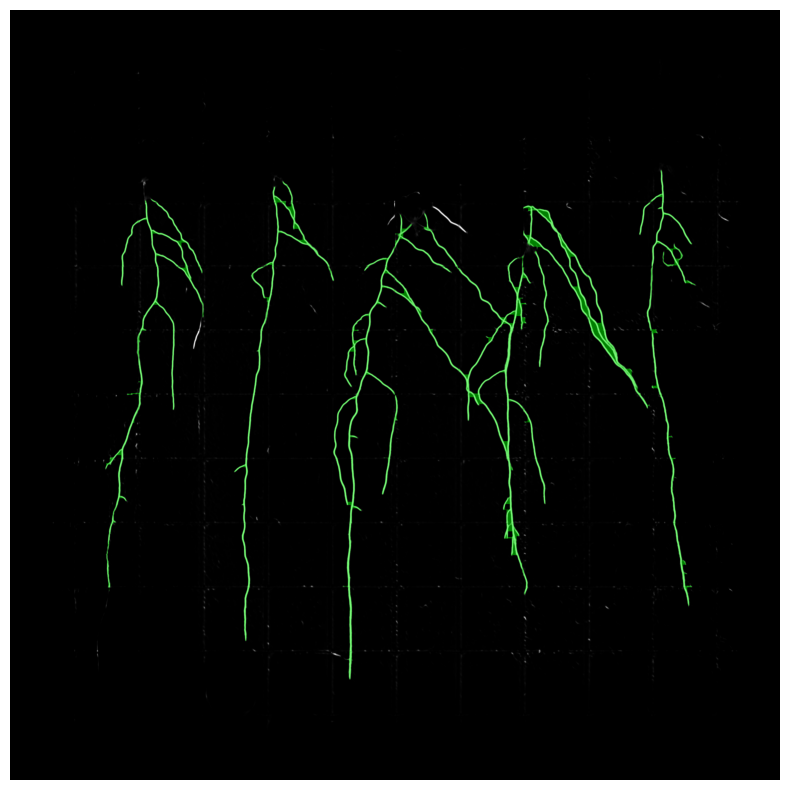

In [13]:
post_processed_masks = []
for img in predicted_masks:
        mask = process_mask(img)
        overlay = img.copy()
        overlay = cv2.cvtColor(overlay, cv2.COLOR_GRAY2BGR)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        overlay[mask == 255] = (0, 255, 0)  # Green color for the overlay of the mask

        # Combine the image and the overlay
        alpha = 0.5  # Transparency factor.
        combined = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)

        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(combined, cv2.COLOR_BGR2RGB))
        plt.axis('off')  # Hide the axis
        post_processed_masks.append(mask)

plt.show()


In [14]:
skeletonized = []

for index, mask in enumerate(post_processed_masks):
    _, binary_image = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    skelmask = skeletonize(binary_image)
    skeletonized.append(skelmask)
    print(index)

0
1
2


In [15]:
simple_skeleton_branch_data = {}
for i, skel in enumerate(skeletonized):
    if not np.any(skel):  # Check if the image is not all zeros
        print(f"Skeletonized image at index {i} is empty.")
    else:
        # Process non-empty skeletons
        simple_skeleton_branch_data[i] = summarize(Skeleton(skel))
        simple_skeleton_branch_data[i].sort_values(by="branch-distance", ascending=False)

In [16]:
def assign_plant_id(x_coordinate):
    if x_coordinate < 750:
        return 1
    elif x_coordinate < 1250:
        return 2
    elif x_coordinate < 1750:
        return 3
    elif x_coordinate < 2250:
        return 4
    else:
        return 5

In [17]:
points = []
def draw_main_root(image, skeleton_branch_data, u):
    info_image = np.copy(image).astype(np.uint8)  # Convert to uint8 if needed
    info_image *= 255

    for skeleton_id, group in skeleton_branch_data.groupby('skeleton-id'):
        G = nx.Graph()
        for index, row in group.iterrows():
            src = (int(row['image-coord-src-1']), int(row['image-coord-src-0']))
            dst = (int(row['image-coord-dst-1']), int(row['image-coord-dst-0']))
            length = row['branch-distance']  # The actual length of the branch segment
            G.add_edge(src, dst, weight=length)
        lowest_point = max(G.nodes, key=lambda point: point[1])
        points.append(lowest_point)
        cv2.circle(info_image, lowest_point, 10, (255, 0, 255), -1)

    # Display the image with the longest paths drawn
    plt.figure(figsize=(12, 12))
    plt.imshow(info_image)
    plt.axis('off')
    plt.show()

    return points

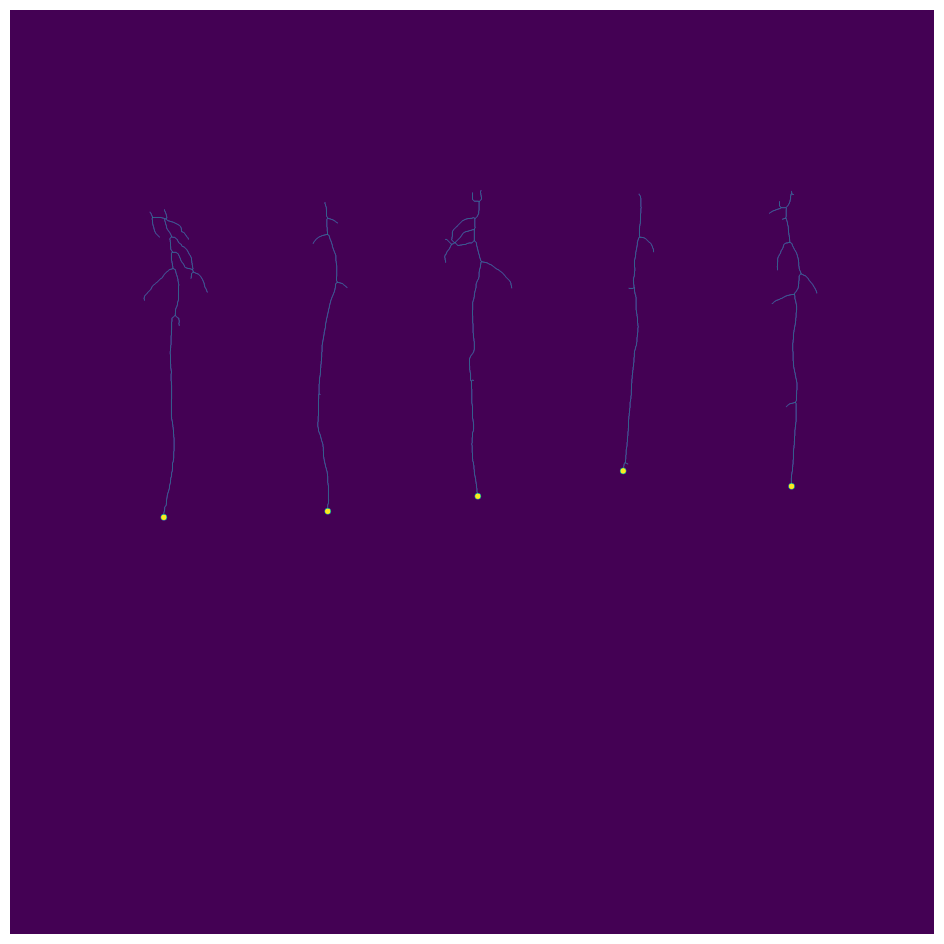

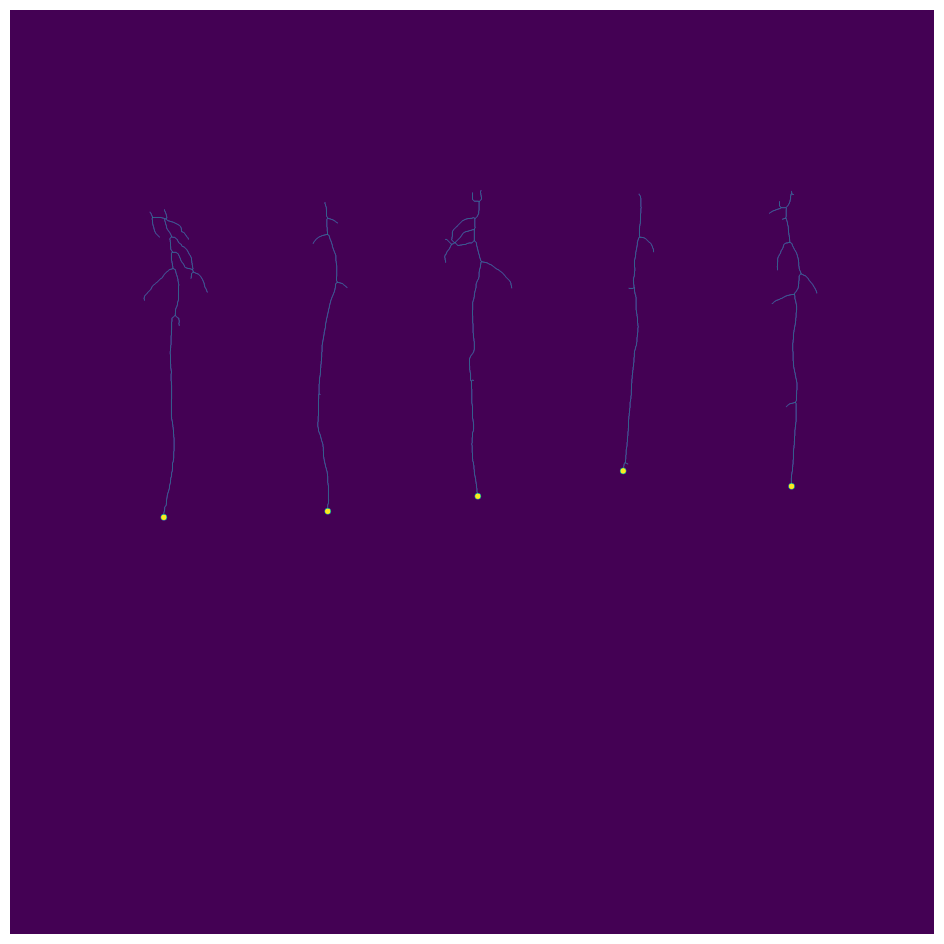

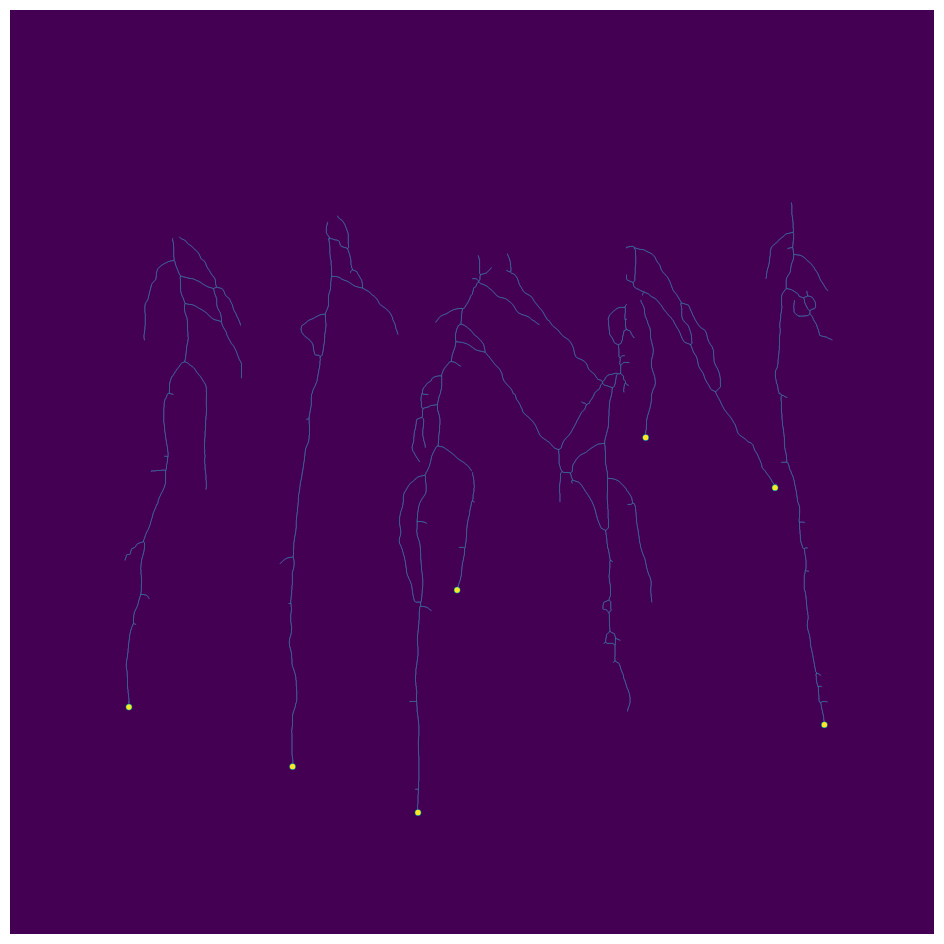

In [18]:
for i, image in enumerate(skeletonized):
    if not np.any(image):  # Check if the image is not all zeros
        print(f"Skeletonized image at index {i} is empty.")
    else:
        points = draw_main_root(image, simple_skeleton_branch_data[i], i)

In [19]:
def get_meter_coordinates(point):
    # Conversion factor from pixels to meters
    start_point = np.array([0.10775, 0.088])
    pixels_per_meter = 24.52 * 1000     #0.10775, 0.088, 0.057
    point_in_meters = np.array([point[1 - i] / pixels_per_meter for i in range(2)])


    return np.array([start_point[i] + point_in_meters[i] for i in range(2)])

In [20]:
import time
error_rl = []
env = OT2Env(render=True)
model = PPO.load(r"C:\Users\benjm\Downloads\model.zip", env=env)

sorted_points = sorted(points[:5], key=lambda p: p[0])
for point in sorted_points:
    obs, info = env.reset()
    point = get_meter_coordinates(point)
    env.goal_position = np.append(point, 0.2895)
    self_set_goal = False
    while not self_set_goal:
        obs = np.array(obs)
        action, _states = model.predict(obs,deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        distance = np.linalg.norm(obs[:3] - obs[3:])
        error_rl.append(distance)
        if distance < 0.01:
            self_set_goal = True
            time.sleep(1)

env.close()

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [21]:
# Importing the libraries
from simple_pid import PID
import time
import numpy as np
import sys
import pandas as pd
sys.path.insert(1, r'C:\Users\benjm\Documents\GitHub\2023-24-fai2-adsai-BenjaminGraziadei223946\3. Reinforcement Learning')
from ot2_env_wrapper import OT2Env

# Importing the environment
env = OT2Env()

# Creating the PID controllers for each axis
pid_controller_x = PID(Kp=15, Ki=0, Kd=0)
pid_controller_y = PID(Kp=15, Ki=0, Kd=0)
pid_controller_z = PID(Kp=15, Ki=0, Kd=0)

# Creatin a variable to store the error
overall_error = []

# Starting the timer
start = time.time()

for point in sorted_points:
    observation, info = env.reset(goal_position=np.array(np.append(get_meter_coordinates(point), 0.2895)))

    # Setting the goal position for each axis
    pid_controller_x.setpoint = env.goal_position[0]
    pid_controller_y.setpoint = env.goal_position[1]
    pid_controller_z.setpoint = env.goal_position[2]
    # Setting termination and truncation false
    terminated = False
    truncated = False

    # Setting the epoch to 0 to start the loop
    epoch = 0

    # Looping through 500 epochs
    for i in range(200):

        # Breaking the loop if terminated
        if terminated:
            break

        # Incrementing the epoch
        epoch += 1

        # Resetting the environment if truncated
        if truncated:
            observation, info = env.reset()

            # Resetting the goal positions for each axis if truncated
            pid_controller_x.setpoint = env.goal_position[0]
            pid_controller_y.setpoint = env.goal_position[1]
            pid_controller_z.setpoint = env.goal_position[2]

        # Getting the actions for each axis
        action_x = pid_controller_x(observation[0])
        action_y = pid_controller_y(observation[1])
        action_z = pid_controller_z(observation[2])

        # Creating the action array
        action = np.array([action_x, action_y, action_z, 0])

        # Taking a step in the environment
        observation, _, terminated, truncated, _ = env.step(action)

        # Getting the distance between the pipette and the goal
        distance = observation[3:] - observation[:3] # goal position - pipette position

        # Calculating the error between the pipette and the goal
        error = np.linalg.norm(distance)

        # Adding the error to the overall error
        overall_error.append(error)
        
        # Printing the epoch, goal position and observation
        print(f"Epoch: {epoch}")
        print(f"Observation: {observation}")
        # Adding a delay
        time.sleep(0.0003)

# Ending the timer
end = time.time()

# Printing the time taken
print(f"Time taken: {end - start}")


Epoch: 1
Observation: [0.0735     0.0901     0.1205     0.1765102  0.10884013 0.2895    ]
Epoch: 2
Observation: [0.0744     0.0912     0.1224     0.1765102  0.10884013 0.2895    ]
Epoch: 3
Observation: [0.0757     0.0923     0.1253     0.1765102  0.10884013 0.2895    ]
Epoch: 4
Observation: [0.0776     0.0933     0.1291     0.1765102  0.10884013 0.2895    ]
Epoch: 5
Observation: [0.0799     0.0943     0.1339     0.1765102  0.10884013 0.2895    ]
Epoch: 6
Observation: [0.0826     0.0952     0.141      0.1765102  0.10884013 0.2895    ]
Epoch: 7
Observation: [0.0858     0.096      0.1491     0.1765102  0.10884013 0.2895    ]
Epoch: 8
Observation: [0.0895     0.0969     0.1581     0.1765102  0.10884013 0.2895    ]
Epoch: 9
Observation: [0.0936     0.0976     0.1663     0.1765102  0.10884013 0.2895    ]
Epoch: 10
Observation: [0.0982     0.0983     0.174      0.1765102  0.10884013 0.2895    ]
Epoch: 11
Observation: [0.1031     0.099      0.1812     0.1765102  0.10884013 0.2895    ]
Epoch: 1

In [22]:
print(len(error_rl))

533


In [23]:
print(len(overall_error))

438


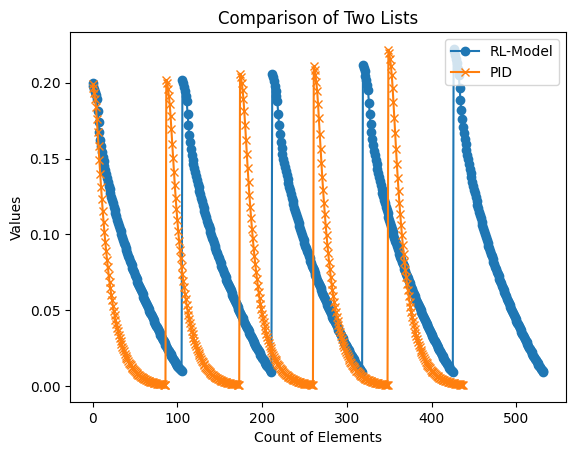

In [24]:
x_rl = range(len(error_rl))
x_pid = range(len(overall_error))
plt.plot(x_rl, error_rl, label='RL-Model', marker='o')
plt.plot(x_pid, overall_error, label='PID', marker='x')

# Adding labels and legend
plt.xlabel('Count of Elements')
plt.ylabel('Values')
plt.title('Comparison of Two Lists')
plt.legend()

# Display the graph
plt.show()